In [1]:
!ls

0218-gpt2.ipynb  data  submission.csv  submission_integers.csv


In [2]:
!pip install transformers

In [3]:
import pandas as pd
import numpy as np
import urllib.request
import os
from tqdm import tqdm
import tensorflow as tf
from transformers import AutoTokenizer, TFGPT2Model
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
train_data_path ="~/aiffel/dktc/data/train.csv"
train_data = pd.read_csv(train_data_path)
train_data.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [5]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 3950


In [6]:
train_data.isnull().values.any()

False

In [7]:
train_data['conversation'].duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
3945    False
3946    False
3947    False
3948    False
3949    False
Name: conversation, Length: 3950, dtype: bool

In [8]:
duplicated = train_data[train_data['conversation'].duplicated()]
duplicated

,idx,class,conversation
392,392,기타 괴롭힘 대화,병신이 아이스크림 먹게 돼 있냐?\n난 먹으면 안 돼? 그만 좀 해.\n당연히 안 ...
523,523,직장 내 괴롭힘 대화,과장님. 저 이번에 휴가 좀 갔다와도 되겠습니까.?\n휴가? 왜??\n좀 쉬다가 오...
789,789,기타 괴롭힘 대화,야 얘 이 쪽 손가락 세 개밖에 없다\n엥 손가락이 세개밖에 없을 수가 있어?\n봐...
824,824,기타 괴롭힘 대화,이야 내동생 여자친구한테 편지쓰네?\n 아 형 돌려줘.\n 어디보자. 사랑하는 여친...
869,869,직장 내 괴롭힘 대화,지현씨 나 소개팅 좀 시켜줘봐\n네? 저 주변에 아는 사람이 없어서요\n아 상사라 ...
...,...,...,...
3797,3797,기타 괴롭힘 대화,너 이번 방학 때 쌍꺼풀 수술 하고왔지?\n아닌데?\n아니긴 뭐가 아니야. 눈이 이...
3798,3798,기타 괴롭힘 대화,안녕하세요 지금 먹방 촬영중인데 촬영가능할까요?\n안돼요\n한번만 안될까요?\n안돼...
3855,3855,기타 괴롭힘 대화,그 소문 진짜야? 너가 다른 애들 뒷담화하고 다녔다며?\n응? 나 그런 적 없는데?...
3874,3874,기타 괴롭힘 대화,야 니 왤캐 못생겼냐?\n뭐라그랬냐?\n으 나 보고 말하지마 니 얼굴보면 토나올거 ...


In [9]:
# document 열에서 중복인 내용이 있다면 중복 제거
train_data.drop_duplicates(subset=['conversation'], inplace=True)
# Null 값이 존재하는 행 제거
train_data = train_data.dropna(how='any')
print('훈련 데이터의 리뷰 수 :',len(train_data))

훈련 데이터의 리뷰 수 : 3846


In [10]:
labels, class_names = pd.factorize(train_data['class'])
train_data['label'] = labels.reshape(-1,1)
train_data.head()

def decode_label(encoded_label):
    return class_names[encoded_label]

In [11]:
train_data['class'].value_counts()

기타 괴롭힘 대화      1011
갈취 대화           973
직장 내 괴롭힘 대화     970
협박 대화           892
Name: class, dtype: int64

In [12]:
train_data['label'].value_counts()

1    1011
2     973
3     970
0     892
Name: label, dtype: int64

In [13]:
tokenizer = AutoTokenizer.from_pretrained('skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', pad_token='<pad>')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [14]:
train_data['length'] = train_data['conversation'].apply(len)

In [15]:
train_data['length'].idxmax()

1213

In [16]:
train_data['length'][1213]

874

In [17]:
train_data['conversation'][1213]

'네 아버님 안녕하십니까. 저는 따님의 남편이 될 길동 입니다.\n어. 어서 오시게. 진짜 훤칠하네 우리 딸이 한눈에 반할만 해. 혹시 가족은 어떻게 되나?\n저는 아버지 어머니 여동생 둘 이렇게 두고 있어요.\n내가 보기와 다르게 대학교 공과대학 출신이야. 뭐 학벌 그렇게 중요하게 생각하지는 않는데. 부모님 학력은 어떻게 되나.?\n저희 부모님은 아버지는 고졸이시고 어머니는 대학교 나오셨습니다.\n고졸에 대학교. 대학교는 들어본 적 도 없는 대학교인데. 원래 학력이 낮은 집안이 재정도 떨어지지만 화목하지가 않아. 맨날 지들 서로가 잘났다고 싸워서 솔직히 내가 보기에는 다 머리 빈 애들 같은데 뭐 도토리 키재기에 길기리 노는거지. 그래서 그런데. 내가 당신을 믿어도 되나.? 부모님 두 분 학력이 그러시면 자네도 만만치않게 낮을거 같은데\n아. 저도 똑같이 고졸입니다. 상업고를 졸업하고 바로 취업을 해서.\n이봐이봐 이래서 부모의 학력이 중요해. 혹시 내딸과 결혼하면 애 낳아서 그 애도 고졸이 될지 어떻게알아? 내 딸 학력이 너무 아까운데\n제가 꼭 대학교 보내겠습니다. 공부 열심히 배우게 해서 키울 자신 있습니다.\n내가 고졸 사람 말을 어떻게 믿어. 혹시 알아? 폭력적인 성향이 있을수도 있잖아. 왜 도시별 범죄비율보면 빈곤한 도시가 더 범죄 많이 일어나잖아. 네 집이 어땠을지는 모르겠지만 그렇게 화목하지 않았을거라는것은 내가 장담해.\n아닙니다 아버님. 저희 가족 완전 화목해요! 부모님 두 분 다 서글서글 하시고 있는 자리에서 최선다하고 계시고\n자네 말을 믿기에는 아직 시간이 부족해. 우리 딸이 또 시집 살이 하는데 힘들수도 있고 우리딸 시집은 그래도 가족끼리 대화 많이 하고 서로 잘 배려해주는 곳으로 보내고 싶은데 왜 이런 집안인 애를 좋아하나 모르겠네.'

In [18]:
test = tokenizer.encode(train_data['conversation'][1213])
print(test)
print(len(test))

[9873, 9857, 7177, 25906, 8702, 7895, 23775, 389, 9265, 7162, 9106, 19495, 25533, 10341, 9367, 7244, 9241, 9361, 8006, 389, 9105, 7788, 9114, 7888, 6866, 389, 23971, 739, 8781, 8423, 8702, 7098, 9351, 28062, 20976, 9138, 8705, 7489, 9098, 389, 10039, 7888, 33624, 11649, 9069, 7055, 10604, 37767, 12683, 10375, 39616, 9710, 10917, 10447, 16444, 22507, 9049, 10234, 16835, 16217, 30636, 10454, 22882, 389, 46651, 9245, 7625, 14927, 20680, 9658, 14752, 9111, 9668, 389, 11676, 7177, 9245, 11859, 11649, 9069, 7055, 389, 10604, 8185, 8806, 11676, 32937, 11283, 30052, 8146, 34677, 12231, 16217, 12252, 7816, 10010, 6889, 8216, 8022, 16217, 389, 16217, 7162, 9359, 7655, 9211, 9095, 9712, 16217, 11848, 389, 10353, 49390, 11259, 39942, 11639, 7235, 11615, 31244, 9192, 7541, 9328, 6824, 11492, 389, 12829, 7060, 9027, 7285, 9919, 6824, 9443, 7065, 9217, 10406, 19647, 12980, 8264, 8811, 17582, 9049, 11351, 9054, 11980, 9818, 9831, 7285, 9239, 7220, 46651, 9095, 25145, 10252, 8170, 9399, 9367, 6958, 747

In [19]:
def convert_examples_to_features(examples, labels, max_seq_len, tokenizer):
    input_ids, data_labels = [], []

    for example, label in tqdm(zip(examples, labels), total=len(examples)):

        bos_token = [tokenizer.bos_token]
        eos_token = [tokenizer.eos_token]
        tokens = bos_token + tokenizer.tokenize(example) + eos_token
        input_id = tokenizer.convert_tokens_to_ids(tokens)
        input_id = pad_sequences([input_id], maxlen=max_seq_len, value=tokenizer.pad_token_id, padding='post')[0]

        assert len(input_id) == max_seq_len, "Error with input length {} vs {}".format(len(input_id), max_seq_len)
        input_ids.append(input_id)
        data_labels.append(label)

    input_ids = np.array(input_ids, dtype=int)
    data_labels = np.asarray(data_labels, dtype=np.int32)

    return input_ids, data_labels

In [20]:
max_idx = train_data['length'].idxmax()
temp = tokenizer.encode(train_data['conversation'][max_idx])
max_seq_len = len(temp)
print(f'max seq len : {max_seq_len}')

train_X, train_y = convert_examples_to_features(train_data['conversation'], train_data['label'], max_seq_len=max_seq_len, tokenizer=tokenizer)

max seq len : 404


100%|██████████| 3846/3846 [00:01<00:00, 2142.03it/s]


In [21]:
input_id = train_X[0]
label = train_y[0]

print('단어에 대한 정수 인코딩 :',input_id)
print('각 인코딩의 길이 :', len(input_id))
print('정수 인코딩 복원 :',tokenizer.decode(input_id))
print('레이블 :',label)

단어에 대한 정수 인코딩 : [    1  9782 10099 24775 30707 24833  9831  8104  9033 12657 19635 35691
 12521 11482  7832 11387 14909  9122  7532 16288 40401  9351  9168 20683
 31424 12906  9098   406 23971 30707 40809 13358  6866  9585 29205 12222
  8718 10010 10099  6824 11814  8711   389 10099  6824 14909  7383  9873
 24173 30707  8239 21598 11482  7832 37194 29205 12222  8718 10010 10099
 12333 11814 11067 10811   389 11814  9350 16337 10099  8066  9873 10464
  9168  9079 28936 30707  7621  7481  6853  7991  9585 11814  9350 26616
 16691 15354  7489 35498 41547 25689  9054 30707  7621 27436  6872  6921
   389 15577 33473 10604  9037  7601 35498  7801 25856     1     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     

In [22]:
model = TFGPT2Model.from_pretrained('skt/kogpt2-base-v2', from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFGPT2Model: ['transformer.h.5.attn.masked_bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.6.attn.masked_bias', 'lm_head.weight', 'transformer.h.7.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.3.attn.masked_bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.8.attn.masked_bias', 'transformer.h.9.attn.masked_bias', 'transformer.h.2.attn.masked_bias']
- This IS expected if you are initializing TFGPT2Model from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2Model from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All t

In [23]:
input_ids_layer = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32)
outputs = model([input_ids_layer])

In [24]:
import tensorflow as tf
from transformers import TFGPT2Model

class TFGPT2ForSequenceClassification(tf.keras.Model):
    def __init__(self, model_name, num_labels):
        super(TFGPT2ForSequenceClassification, self).__init__()
        
        self.gpt = TFGPT2Model.from_pretrained(model_name, from_pt=True)
        # 클래스 개수 저장
        self.num_labels = num_labels
        self.dropout = tf.keras.layers.Dropout(0.2)
        
        self.classifier = tf.keras.layers.Dense(
            # 출력 뉴런 수 = 클래스 개수
            num_labels,
            kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02),
            # 다중 클래스 분류이므로 softmax 사용
            activation='softmax',
            name='classifier')

    def call(self, inputs):
        outputs = self.gpt(input_ids=inputs)
        # 마지막 토큰 가져오기
        cls_token = outputs[0][:, -1]
        cls_token = self.dropout(cls_token)
        prediction = self.classifier(cls_token)

        return prediction

In [25]:
os.environ

environ{'MINICONDA_VERSION': '4.9.2',
        'NV_CUDA_COMPAT_PACKAGE': 'cuda-compat-11-4',
        'NV_LIBCUBLAS_VERSION': '11.6.1.51-1',
        'KUBERNETES_PORT': 'tcp://10.88.0.1:443',
        'KUBERNETES_SERVICE_PORT': '443',
        'LANGUAGE': 'en_US:en',
        'WYB2EZH2OX5S7L4POLLHKNT2X_PORT': 'tcp://10.88.1.216:8888',
        'WYB2EZH2OX5S7L4POLLHKNT2X_SERVICE_PORT': '8888',
        'HOSTNAME': 'wyb2ezh2ox5s7l4pollhknt2x-86d44c9c7f-ln8qb',
        'LD_LIBRARY_PATH': '/usr/local/nvidia/lib:/usr/local/nvidia/lib64',
        'NV_LIBNCCL_PACKAGE_VERSION': '2.11.4-1',
        'HOME': '/aiffel',
        'NV_CUDNN_PACKAGE_NAME': 'libcudnn8',
        'CONDA_VERSION': '4.9.2',
        'TF_CPP_MIN_LOG_LEVEL': '3',
        'WYB2EZH2OX5S7L4POLLHKNT2X_PORT_8887_TCP_ADDR': '10.88.1.216',
        'WYB2EZH2OX5S7L4POLLHKNT2X_PORT_8888_TCP_ADDR': '10.88.1.216',
        'NV_LIBNPP_PACKAGE': 'libnpp-11-4=11.4.0.110-1',
        'CUDA_VERSION': '11.4.2',
        'NV_CUDNN_PACKAGE': 'libcudnn8=8.2

In [26]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Tue Feb 18 12:39:18 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.01             Driver Version: 535.216.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T

In [27]:
strategy = tf.distribute.MirroredStrategy() if tf.config.list_physical_devices('GPU') else tf.distribute.get_strategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [35]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_path = os.getenv('HOME')+'/aiffel/dktc/checkpoint.weights.h5'

with strategy.scope():
  model = TFGPT2ForSequenceClassification(model_name="skt/kogpt2-base-v2", num_labels=5)
  optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
  # from_logits=False (Softmax 출력)
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

  es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
  mc = ModelCheckpoint(checkpoint_path, save_weights_only=True, monitor='val_loss', save_best_only=True, verbose=1)

  model.compile(optimizer=optimizer, loss=loss, metrics = ['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFGPT2Model: ['transformer.h.5.attn.masked_bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.6.attn.masked_bias', 'lm_head.weight', 'transformer.h.7.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.3.attn.masked_bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.8.attn.masked_bias', 'transformer.h.9.attn.masked_bias', 'transformer.h.2.attn.masked_bias']
- This IS expected if you are initializing TFGPT2Model from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2Model from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All t

In [36]:
history = model.fit(train_X, train_y, epochs=10, batch_size=8, callbacks=[es, mc], validation_split=0.2)

Epoch 1/10
385/385 [==============================] - 339s 840ms/step - loss: 1.0544 - accuracy: 0.6170 - val_loss: 0.5611 - val_accuracy: 0.8091

Epoch 00001: val_loss improved from inf to 0.56113, saving model to /aiffel/aiffel/dktc/checkpoint.weights.h5
Epoch 2/10
385/385 [==============================] - 320s 832ms/step - loss: 0.4875 - accuracy: 0.8410 - val_loss: 0.5761 - val_accuracy: 0.8143

Epoch 00002: val_loss did not improve from 0.56113
Epoch 3/10
385/385 [==============================] - 320s 832ms/step - loss: 0.2874 - accuracy: 0.9080 - val_loss: 0.6240 - val_accuracy: 0.8390

Epoch 00003: val_loss did not improve from 0.56113
Epoch 00003: early stopping


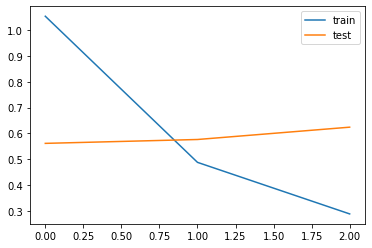

In [37]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [38]:
import pandas as pd
import json

test_json_path = os.getenv('HOME')+'/aiffel/dktc/data/test.json'

# JSON 파일 불러오기
with open(test_json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# 변환: key를 인덱스로 하고, 내부 "text" 값을 컬럼으로 변환
test_data = pd.DataFrame.from_dict(data, orient="index")
test_data.head()

,text
t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
t_003,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...
t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...


In [39]:
model.load_weights(checkpoint_path)

def classify(sentence):
  bos_token = [tokenizer.bos_token]
  eos_token = [tokenizer.eos_token]

  tokens = bos_token + tokenizer.tokenize(sentence) + eos_token
  input_id = tokenizer.convert_tokens_to_ids(tokens)

  input_id = pad_sequences([input_id], maxlen=max_seq_len, value=tokenizer.pad_token_id, padding='post')[0]
  input_id = np.array([input_id])

  scores = model.predict(input_id)[0]
  # 가장 높은 확률을 가진 클래스 선택
  predicted_class = np.argmax(scores)
  confidence = np.max(scores) * 100

  return decode_label(predicted_class)

In [40]:
test_data['text'][0]

'아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나보네 그럼 취소할까요 아가씨 내 여기단골이니 담에 갖다줄께 저도 알바생이라 외상안됩니다 아따 누가 떼먹는다고 그러나 갖다준다고 안됩니다 자꾸이럼 경찰불러요 아가씨 담배피는교 그건 왜 물으세요 그람 아가씨 담배 한대만 빌립시다 내 지금 지갑도 잃어버리고 기분이 그래서 그러니 여기요  아따 주는김에 한개더 주면 되겠네'

In [41]:
classify(test_data['text'][0])

'갈취 대화'

In [42]:
test_data['class'] = test_data['text'].apply(classify)
test_data.head()

,text,class
t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...,갈취 대화
t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...,직장 내 괴롭힘 대화
t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...,기타 괴롭힘 대화
t_003,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...,기타 괴롭힘 대화
t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...,갈취 대화


In [43]:
output_df = test_data[['class']].reset_index()
output_df.rename(columns={'index': 'file_name'}, inplace=True)

output_df.head()

,file_name,class
0,t_000,갈취 대화
1,t_001,직장 내 괴롭힘 대화
2,t_002,기타 괴롭힘 대화
3,t_003,기타 괴롭힘 대화
4,t_004,갈취 대화


In [44]:
csv_path = os.getenv('HOME')+'/aiffel/dktc/submission.csv'
output_df.to_csv(csv_path, index=False)